# Mini Project: Recommendation Engines

Recommendation engines are algorithms designed to provide personalized suggestions or recommendations to users. These systems analyze user behavior, preferences, and interactions with items (products, movies, music, articles, etc.) to predict and offer items that users are likely to be interested in. Recommendation engines play a crucial role in enhancing user experience, driving engagement, and increasing conversion rates in various applications, including e-commerce, entertainment, content platforms, and more.

There are generally two approaches taken in collaborative filtering and content-based recommendation engines:

**1. Collaborative Filtering:**
Collaborative Filtering is a popular approach to building recommendation systems that leverages the collective behavior of users to make personalized recommendations. It is based on the idea that users who have agreed in the past will likely agree in the future. There are two main types of collaborative filtering:

- **User-based Collaborative Filtering:** This method finds users similar to the target user based on their past interactions (e.g., ratings or purchases). It then recommends items that similar users have liked but the target user has not interacted with yet.

- **Item-based Collaborative Filtering:** In this approach, the system identifies similar items based on user interactions. It recommends items that are similar to the ones the target user has already liked or interacted with.

Collaborative filtering does not require any explicit information about items but relies on the similarity between users or items. It is effective in capturing complex patterns and can provide serendipitous recommendations. However, it suffers from the cold-start problem (i.e., difficulty in recommending to new users or items with no interactions) and scalability challenges in large datasets.

**2. Content-Based Recommendation:**
Content-based recommendation is an alternative approach to building recommendation systems that focuses on the attributes or features of items and users. It leverages the characteristics of items to make recommendations. The key steps involved in content-based recommendation are:

- **Feature Extraction:** For each item, relevant features are extracted. For movies, these features could be genre, director, actors, and plot summary.

- **User Profile:** A user profile is created based on the items they have interacted with in the past. The user profile contains the weighted importance of features based on their interactions.

- **Similarity Calculation:** The similarity between items or between items and the user profile is calculated using similarity metrics like cosine similarity or Euclidean distance.

- **Recommendation:** Items that are most similar to the user profile are recommended to the user.

Content-based recommendation systems are less affected by the cold-start problem as they can still recommend items based on their features. They are also more interpretable as they rely on item attributes. However, they may miss out on providing serendipitous recommendations and can be limited by the quality of feature extraction and user profiles.

**Choosing Between Collaborative Filtering and Content-Based:**
Both collaborative filtering and content-based approaches have their strengths and weaknesses. The choice between them depends on the specific requirements of the recommendation system, the type of data available, and the user base. Hybrid approaches that combine collaborative filtering and content-based techniques are also common, aiming to leverage the strengths of both methods and mitigate their weaknesses.

In this mini-project, you'll be building both content based and collaborative filtering engines for the [MovieLens 25M dataset](https://grouplens.org/datasets/movielens/25m/). The MovieLens 25M dataset is one of the most widely used and popular datasets for building and evaluating recommendation systems. It is provided by the GroupLens Research project, which collects and studies datasets related to movie ratings and recommendations. The MovieLens 25M dataset contains movie ratings and other related information contributed by users of the MovieLens website.

**Dataset Details:**
- **Size:** The dataset contains approximately 25 million movie ratings.
- **Users:** It includes ratings from over 162,000 users.
- **Movies:** The dataset consists of ratings for more than 62,000 movies.
- **Ratings:** The ratings are provided on a scale of 1 to 5, where 1 is the lowest rating and 5 is the highest.
- **Timestamps:** Each rating is associated with a timestamp, indicating when the rating was given.

**Data Files:**
The dataset is usually split into three CSV files:

1. **movies.csv:** Contains information about movies, including the movie ID, title, genres, and release year.
   - Columns: movieId, title, genres

2. **ratings.csv:** Contains movie ratings provided by users, including the user ID, movie ID, rating, and timestamp.
   - Columns: userId, movieId, rating, timestamp

3. **tags.csv:** Contains user-generated tags for movies, including the user ID, movie ID, tag, and timestamp.
   - Columns: userId, movieId, tag, timestamp

First, import all the libraries you'll need.

In [1]:
import zipfile
import numpy as np
import pandas as pd
from urllib.request import urlretrieve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


Next, download the relevant components of the MoveLens dataset. Note, these instructions are roughly based on the colab [here](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=O3bcgduFo4s6).

In [2]:
print("Downloading movielens data...")

urlretrieve('http://files.grouplens.org/datasets/movielens/ml-100k.zip', 'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip', 'r')
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


Before doing any kind of machine learning, it's always good to familiarize yourself with the datasets you'lll be working with.

Here are your tasks:

1. Spend some time familiarizing yourself with both the `movies` and `ratings` dataframes. How many unique user ids are present? How many unique movies are there?
2. Create a new dataframe that merges the `movies` and `ratings` tables on 'movie_id'. Only keep the 'user_id', 'title', 'rating' fields in this new dataframe.

In [3]:
# Spend some time familiarizing yourself with both the movies and ratings
# dataframes. How many unique user ids are present? How many unique movies
# are there?
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
print(ratings.shape)
print(movies.shape)

(100000, 4)
(1682, 24)


In [6]:
user_count = ratings['user_id'].nunique()
movie_count = movies['movie_id'].nunique()

print(f"Number of unique IDs: {user_count}")
print(f"Movie Count: {movie_count}")

Number of unique IDs: 943
Movie Count: 1682


In [7]:
print(ratings.isnull().sum())

user_id           0
movie_id          0
rating            0
unix_timestamp    0
dtype: int64


In [8]:
print(movies.isnull().sum())

movie_id                 0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
genre_unknown            0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64


In [9]:
# Merge movies and ratings dataframes

merged_df = pd.merge(movies, ratings, on='movie_id')[['user_id', 'title', 'rating']]
merged_df.head()

,user_id,title,rating
0,308,Toy Story (1995),4
1,287,Toy Story (1995),5
2,148,Toy Story (1995),4
3,280,Toy Story (1995),4
4,66,Toy Story (1995),3


In [10]:
merged_df.shape

(100000, 3)

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  100000 non-null  int64 
 1   title    100000 non-null  object
 2   rating   100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [12]:
merged_df.columns

Index(['user_id', 'title', 'rating'], dtype='object')

In [13]:
col_list = ['user_id', 'title', 'rating']

for i in col_list:
  print(merged_df[i].value_counts())

user_id
405    737
655    685
13     636
450    540
276    518
      ... 
636     20
873     20
93      20
309     20
895     20
Name: count, Length: 943, dtype: int64
title
Star Wars (1977)                                583
Contact (1997)                                  509
Fargo (1996)                                    508
Return of the Jedi (1983)                       507
Liar Liar (1997)                                485
                                               ... 
Tigrero: A Film That Was Never Made (1994)        1
Eye of Vichy, The (Oeil de Vichy, L') (1993)      1
Promise, The (Versprechen, Das) (1994)            1
To Cross the Rubicon (1991)                       1
Scream of Stone (Schrei aus Stein) (1991)         1
Name: count, Length: 1664, dtype: int64
rating
4    34174
3    27145
5    21201
2    11370
1     6110
Name: count, dtype: int64


As mentioned in the introduction, content-Based Filtering is a recommendation engine approach that focuses on the attributes or features of items (products, movies, music, articles, etc.) and leverages these features to make personalized recommendations. The underlying idea is to match the characteristics of items with the preferences of users to suggest items that align with their interests. Content-based filtering is particularly useful when explicit user-item interactions (e.g., ratings or purchases) are sparse or unavailable.

**Key Steps in Content-Based Filtering:**

1. **Feature Extraction:**
   - For each item, relevant features are extracted. These features are typically descriptive attributes that can be represented numerically, such as genre, director, actors, author, publication date, and keywords.
   - In the case of text-based items, natural language processing techniques may be used to extract features like TF-IDF (Term Frequency-Inverse Document Frequency) scores.

2. **User Profile Creation:**
   - A user profile is created based on the items they have interacted with in the past. The user profile contains the weighted importance of features based on their interactions.
   - For example, if a user has watched several action movies, the action genre feature would receive a higher weight in their profile.

3. **Similarity Calculation:**
   - The similarity between items or between items and the user profile is calculated using similarity metrics like cosine similarity, Euclidean distance, or Pearson correlation.
   - Cosine similarity is commonly used as it measures the cosine of the angle between two vectors, which represents their similarity.

4. **Recommendation:**
   - Items that are most similar to the user profile are recommended to the user. These are items whose features have the highest similarity scores with the user profile.
   - The recommended items are presented as a list sorted by their similarity scores.

**Advantages of Content-Based Filtering:**
1. **No Cold-Start Problem:** Content-based filtering can make recommendations even for new users with no historical interactions because it relies on item features rather than user history.

2. **User Independence:** The recommendations are based solely on the features of items and do not require knowledge of other users' preferences or behavior.

3. **Transparency:** Content-based recommendations are interpretable, as they depend on the features of items, making it easier for users to understand why specific items are recommended.

4. **Serendipity:** Content-based filtering can recommend items with characteristics not seen before by the user, leading to serendipitous discoveries.

5. **Diversity in Recommendations:** The method can offer diverse recommendations since it suggests items with different feature combinations.

**Limitations of Content-Based Filtering:**
1. **Limited Discovery:** Content-based filtering may struggle to recommend items outside the scope of users' historical interactions or interests.

2. **Over-Specialization:** Users may receive recommendations that are too similar to their previous choices, leading to a lack of exposure to new item categories.

3. **Dependency on Feature Quality:** The quality and relevance of item features significantly influence the quality of recommendations.

4. **Limited for Cold Items:** Content-based filtering can struggle to recommend new items with limited feature information.

Here is your task:

1. Write a function that takes in a user id and the dataframe you created before that contains 'user_id', 'title', and 'rating'. The function should return content-based recommendations for this user. Here are steps you can take:

  A. Get the user's rated movies

  B. Create a TF-IDF matrix using movie genres. Note, this can be extracted from the `movies` dataframe.

  C. Compute the cosine similarity between movie genres. Use the [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) function.

  D. Get the indices of similar movies to those rated by the user based on cosine similarity. Keep only the top 5.

  E. Remove duplicates and movies already rated by the user.

Building Function Step-By-Step

In [14]:
user_ratings = merged_df[merged_df['user_id'] == 405]
user_ratings

,user_id,title,rating
488,405,GoldenEye (1995),1
820,405,Get Shorty (1995),4
912,405,Copycat (1995),4
1483,405,Babe (1995),4
2022,405,Seven (Se7en) (1995),4
...,...,...,...
99815,405,Salut cousin! (1996),1
99817,405,Schizopolis (1996),1
99821,405,"To Have, or Not (1995)",1
99827,405,Duoluo tianshi (1995),1


In [15]:
movies['genres'] = movies[genre_cols].apply(lambda row: ' '.join(row.index[row.astype(bool)]), axis=1)
movies['genres']

0       Animation Children Comedy
1       Action Adventure Thriller
2                        Thriller
3             Action Comedy Drama
4            Crime Drama Thriller
                  ...            
1677                        Drama
1678             Romance Thriller
1679                Drama Romance
1680                       Comedy
1681                        Drama
Name: genres, Length: 1682, dtype: object

In [16]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movies['genres'])
unique_genres = vectorizer.get_feature_names_out()
print(unique_genres)

['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'genre_unknown' 'horror'
 'musical' 'mystery' 'noir' 'romance' 'sci' 'thriller' 'war' 'western']


In [17]:
dense_matrix = np.asarray(tfidf_matrix.todense())

# tfidf_df = pd.DataFrame(dense_matrix, columns=unique_genres)
# print(tfidf_df.head())

In [18]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(dense_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

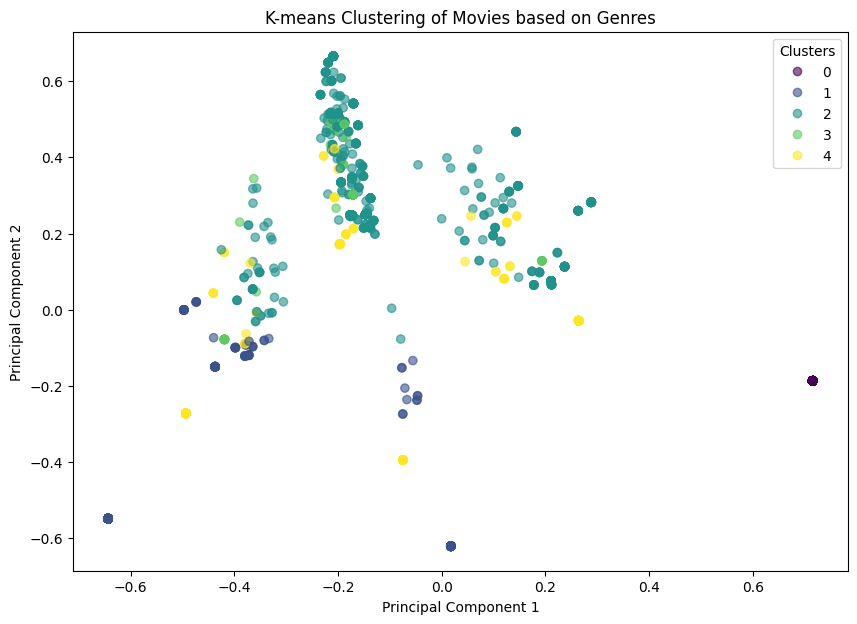

In [19]:
cluster_labels = kmeans.labels_

movies['cluster'] = cluster_labels

pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(dense_matrix)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['cluster'] = cluster_labels

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Movies based on Genres')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [20]:
clusters = [0, 1, 2, 3, 4]

for i in clusters:
  cluster_0_movies = movies[movies['cluster'] == i]
  print(f"Cluster = {i}")
  print(cluster_0_movies[['title', 'genres']])
  print(cluster_0_movies['genres'].value_counts())

Cluster = 0
                                                  title genres
5     Shanghai Triad (Yao a yao yao dao waipo qiao) ...  Drama
8                               Dead Man Walking (1995)  Drama
14                            Mr. Holland's Opus (1995)  Drama
17                            White Balloon, The (1995)  Drama
18                                Antonia's Line (1995)  Drama
...                                                 ...    ...
1674                              Sunchaser, The (1996)  Drama
1675                            War at Home, The (1996)  Drama
1676                               Sweet Nothing (1995)  Drama
1677                                  Mat' i syn (1997)  Drama
1681          Scream of Stone (Schrei aus Stein) (1991)  Drama

[376 rows x 2 columns]
genres
Drama    376
Name: count, dtype: int64
Cluster = 1
                                title                 genres
3                   Get Shorty (1995)    Action Comedy Drama
7                         Ba

In [21]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.34941857,
        0.        ],
       [0.        , 1.        , 0.53676706, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53676706, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.53394963],
       [0.34941857, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.53394963, 0.        ,
        1.        ]])

In [22]:
user_rated_movie_titles = user_ratings['title'].tolist()
user_rated_movie_indices = movies[movies['title'].isin(user_rated_movie_titles)].index
user_rated_movie_indices

Index([   1,    3,    4,    7,   10,   11,   21,   22,   25,   26,
       ...
       1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1616, 1679],
      dtype='int64', length=740)

In [23]:
movies['title']

0                                Toy Story (1995)
1                                GoldenEye (1995)
2                               Four Rooms (1995)
3                               Get Shorty (1995)
4                                  Copycat (1995)
                          ...                    
1677                            Mat' i syn (1997)
1678                             B. Monkey (1998)
1679                         Sliding Doors (1998)
1680                          You So Crazy (1994)
1681    Scream of Stone (Schrei aus Stein) (1991)
Name: title, Length: 1682, dtype: object

In [24]:
user_ratings = merged_df[merged_df['user_id'] == 308]
user_rated_movie_titles = user_ratings['title'].tolist()
sim_scores = cosine_sim[user_rated_movie_indices].mean(axis=0)
sim_scores_indices = sim_scores.argsort()[::-1]
top_5_indices = sim_scores_indices[:5]
top_5_indices

array([1424,  149,  344, 1311, 1310])

In [25]:
user_rated_titles_set = set(user_rated_movie_titles)
recommended_titles = []
for idx in top_5_indices:
    title = movies.iloc[idx]['title']
    if title not in user_rated_titles_set and title not in recommended_titles:
        recommended_titles.append(title)
    if len(recommended_titles) >= 5:
        break

print(recommended_titles)

["I'll Do Anything (1994)", 'Swingers (1996)', 'Deconstructing Harry (1997)', 'Pompatus of Love, The (1996)', 'Waiting to Exhale (1995)']


In [26]:
# Content-Based Filtering using Movie Genres
def content_based_recommendation(user_id, df):
  # Get the user's rated movies
  user_ratings = df[df['user_id'] == user_id]

  # Create a TF-IDF matrix using movie genres
  movies['genres'] = movies[genre_cols].apply(lambda row: ' '.join(row.index[row.astype(bool)]), axis=1)
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform(movies['genres'])

  # Compute the cosine similarity between movie genres
  cosine_sim = cosine_similarity(tfidf_matrix)

  # Get the indices of the similar movies based on cosine similarity
  user_rated_movie_titles = user_ratings['title'].tolist()
  user_rated_movie_indices = movies[movies['title'].isin(user_rated_movie_titles)].index
  sim_scores = cosine_sim[user_rated_movie_indices].mean(axis=0)

  sim_scores_indices = sim_scores.argsort()[::-1]
  # top_5_indices = sim_scores_indices[:5]

  # Remove duplicates and movies already rated by the user

  user_rated_titles_set = set(user_rated_movie_titles)
  recommended_titles = []
  for idx in sim_scores_indices:
      title = movies.iloc[idx]['title']
      if title not in user_rated_titles_set and title not in recommended_titles:
          recommended_titles.append(title)
      if len(recommended_titles) >= 5:
          break

  return recommended_titles

In [27]:
content_based_recommendations = content_based_recommendation(287, merged_df)
print(content_based_recommendations)

['House of Yes, The (1997)', 'Faster Pussycat! Kill! Kill! (1965)', 'Evening Star, The (1996)', 'Paper, The (1994)', 'Salut cousin! (1996)']


The key idea behind collaborative filtering is that users who have agreed in the past will likely agree in the future. Instead of relying on item attributes or user profiles, collaborative filtering identifies patterns of user behavior and item preferences from the interactions present in the data.

**Types of Collaborative Filtering:**
There are two main types of collaborative filtering:

**Collaborative Filtering Process:**
The collaborative filtering process typically involves the following steps:

1. **Data Collection:**
   - Gather data on user-item interactions, such as movie ratings, product purchases, or article clicks.

2. **User-Item Matrix:**
   - Organize the data into a user-item matrix, where rows represent users, columns represent items, and the entries contain the users' interactions (e.g., ratings).

3. **Similarity Calculation:**
   - Calculate the similarity between users or items using similarity metrics such as cosine similarity, Pearson correlation, or Jaccard similarity.
   - For user-based collaborative filtering, user similarities are calculated, and for item-based collaborative filtering, item similarities are calculated.

4. **Neighborhood Selection:**
   - For each user or item, select the most similar users or items as the neighborhood.
   - The size of the neighborhood (the number of similar users or items to consider) is an important parameter to control the system's behavior.

5. **Prediction Generation:**
   - Predict the ratings for items that the target user has not yet interacted with by combining the ratings of neighboring users or items.

6. **Recommendation Generation:**
   - Recommend items with the highest predicted ratings to the target user.

**Advantages of Collaborative Filtering using User-Item Interactions:**
- Collaborative filtering is based solely on user interactions and does not require knowledge of item attributes, making it useful for cases where item data is sparse or unavailable.
- It can provide serendipitous recommendations, suggesting items that users may not have discovered on their own.
- Collaborative filtering can be applied in various domains, including e-commerce, music, movie, and content recommendations.

**Limitations of Collaborative Filtering:**
- The cold-start problem: Collaborative filtering struggles to recommend to new users or items with no or limited interaction history.
- It may suffer from sparsity when data is limited or when users have only interacted with a small subset of items.
- Scalability issues can arise with large datasets and an increasing number of users or items.

Here is your task:

1. Write a function that takes in a user id and the dataframe you created before that contains 'user_id', 'title', and 'rating'. The function should return collaborative filtering recommendations for this user based on a user-item interaction matrix. Here are steps you can take:

  A. Create the user-item matrix using Pandas' [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html).

  B. Fill missing values with zeros in this matrix.

  C. Calculate user-user similarity matrix using cosine similarity.

  D. Get the array of similarity scores of the target user with all other users from the similarity matrix.

  E. Extract, say the the top 5 most similar users (excluding the target user).

  F. Generate movie recommendations based on the most similar users.

  G. Remove duplicate movies recommendations.

Building Function Step-By-Step

In [28]:
merged_df_copy = merged_df.copy()

user_item_matrix = merged_df_copy.pivot_table(index='user_id', columns='title', values='rating', aggfunc='mean')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


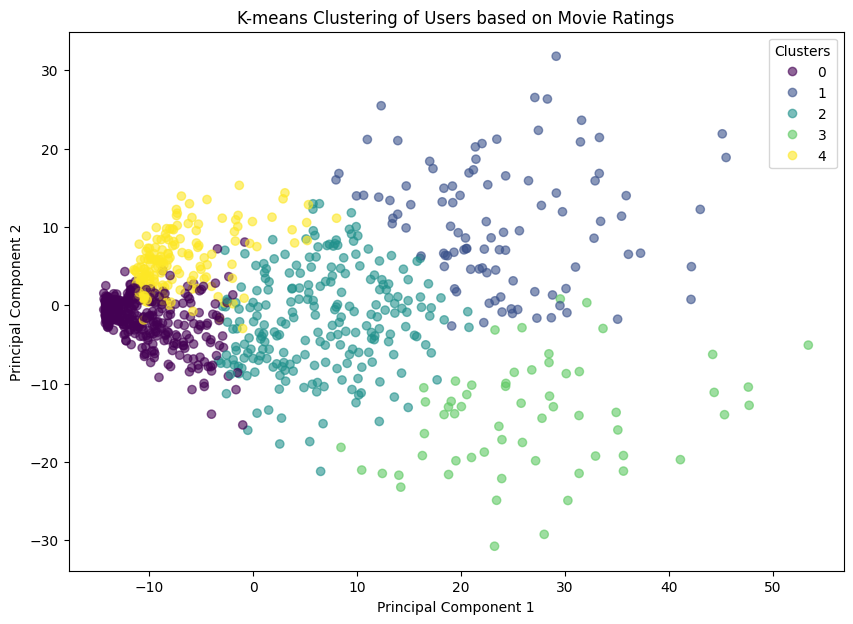

In [29]:
user_item_matrix_array = user_item_matrix_filled.to_numpy()

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(user_item_matrix_array)

user_clusters = kmeans.labels_
user_item_matrix_filled['cluster'] = user_clusters

pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(user_item_matrix_array)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['cluster'] = user_clusters

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Users based on Movie Ratings')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [54]:
clusters = [0, 1, 2, 3, 4]

for i in clusters:
  cluster_0_movies = user_item_matrix_filled[user_item_matrix_filled['cluster'] == i]
  print(f"Cluster = {i}")
  print(cluster_0_movies['cluster'].sum())

Cluster = 0
0
Cluster = 1
99
Cluster = 2
458
Cluster = 3
183
Cluster = 4
668


In [37]:
user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity

array([[1.        , 0.16953636, 0.0483822 , ..., 0.1490673 , 0.1821722 ,
        0.3996289 ],
       [0.16953636, 1.        , 0.11240071, ..., 0.16148478, 0.18040612,
        0.10857601],
       [0.0483822 , 0.11240071, 1.        , ..., 0.10289899, 0.13656936,
        0.02698427],
       ...,
       [0.1490673 , 0.16148478, 0.10289899, ..., 1.        , 0.10236918,
        0.09509815],
       [0.1821722 , 0.18040612, 0.13656936, ..., 0.10236918, 1.        ,
        0.18483919],
       [0.3996289 , 0.10857601, 0.02698427, ..., 0.09509815, 0.18483919,
        1.        ]])

In [38]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
user_similarity_df

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.169536,0.048382,0.064553,0.379949,0.429854,0.443326,0.320395,0.078375,0.378001,...,0.372504,0.120853,0.270188,0.193318,0.198475,0.119767,0.315423,0.149067,0.182172,0.399629
2,0.169536,1.000000,0.112401,0.178121,0.079167,0.246869,0.112399,0.111719,0.161048,0.166512,...,0.150942,0.324892,0.370247,0.407130,0.332419,0.244276,0.233541,0.161485,0.180406,0.108576
3,0.048382,0.112401,1.000000,0.349781,0.021568,0.073907,0.067378,0.084240,0.062039,0.066127,...,0.033858,0.042910,0.166509,0.071288,0.125519,0.026532,0.164302,0.102899,0.136569,0.026984
4,0.064553,0.178121,0.349781,1.000000,0.031768,0.068328,0.091446,0.187661,0.101284,0.060777,...,0.054572,0.036325,0.133115,0.196561,0.145180,0.029947,0.196575,0.152041,0.171303,0.058739
5,0.379949,0.079167,0.021568,0.031768,1.000000,0.240613,0.375794,0.251214,0.056783,0.203398,...,0.341419,0.086966,0.098939,0.080962,0.152747,0.077093,0.241885,0.139438,0.155900,0.314524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.119767,0.244276,0.026532,0.029947,0.077093,0.118730,0.108179,0.103540,0.039599,0.077664,...,0.071001,0.443523,0.267654,0.228606,0.441553,1.000000,0.093966,0.178888,0.050089,0.146058
940,0.315423,0.233541,0.164302,0.196575,0.241885,0.356352,0.332186,0.249494,0.120322,0.344793,...,0.329895,0.113979,0.191919,0.183947,0.179724,0.093966,1.000000,0.144944,0.265672,0.241765
941,0.149067,0.161485,0.102899,0.152041,0.139438,0.145049,0.060135,0.145835,0.143245,0.090183,...,0.047108,0.200763,0.288318,0.237951,0.311516,0.178888,0.144944,1.000000,0.102369,0.095098


In [39]:
similarity_scores = user_similarity_df.loc[405]
similar_users = similarity_scores.drop(405).sort_values(ascending=False).index[:5]
similar_users

Index([846, 94, 311, 194, 276], dtype='int64', name='user_id')

In [40]:
user_rated_movies = set(user_item_matrix_filled.loc[405][user_item_matrix_filled.loc[405] > 0].index)
user_rated_movies

{'1-900 (1994)',
 '12 Angry Men (1957)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 '8 1/2 (1963)',
 'Ace Ventura: Pet Detective (1994)',
 'Ace Ventura: When Nature Calls (1995)',
 'Across the Sea of Time (1995)',
 'Addams Family Values (1993)',
 'Adventures of Priscilla, Queen of the Desert, The (1994)',
 'Age of Innocence, The (1993)',
 'Airheads (1994)',
 'Akira (1988)',
 'Aladdin (1992)',
 'Aladdin and the King of Thieves (1996)',
 'Alice in Wonderland (1951)',
 'Alien (1979)',
 'Alien 3 (1992)',
 'Aliens (1986)',
 'All About Eve (1950)',
 'Amadeus (1984)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 'American Dream (1990)',
 'American President, The (1995)',
 'American Werewolf in London, An (1981)',
 "Amityville 1992: It's About Time (1992)",
 'Amityville 3-D (1983)',
 'Amityville Curse, The (1990)',
 'Amityville Horror, The (1979)',
 'Amityville II: The Possession (1982)',
 'Amityville: A New Generation (1993)',
 'Amityville: Dollho

In [41]:
recommended_movies = pd.Series(dtype='float64')

for similar_user in similar_users:
    similar_user_ratings = user_item_matrix_filled.loc[similar_user]
    for movie, rating in similar_user_ratings.items():
        if movie not in user_rated_movies and rating > 0:
            if movie not in recommended_movies:
                recommended_movies[movie] = rating
            else:
                recommended_movies[movie] += rating

recommended_movies = recommended_movies.sort_values(ascending=False).head(5)
recommended_movies

Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)    19.0
It's a Wonderful Life (1946)                                                   19.0
Casablanca (1942)                                                              18.0
Dead Man Walking (1995)                                                        18.0
Contact (1997)                                                                 17.0
dtype: float64

In [42]:
recommended_movies.index.tolist()

['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 "It's a Wonderful Life (1946)",
 'Casablanca (1942)',
 'Dead Man Walking (1995)',
 'Contact (1997)']

In [43]:
# Collaborative Filtering using User-Item Interactions
def collaborative_filtering_recommendation(user_id, df):
  # Create the user-item matrix
  user_item_matrix = df.pivot_table(index='user_id', columns='title', values='rating', aggfunc='mean')

  # Fill missing values with 0 (indicating no rating)
  user_item_matrix_filled = user_item_matrix.fillna(0)

  # Calculate user-user similarity matrix using cosine similarity
  user_similarity = cosine_similarity(user_item_matrix_filled)

  # Get the similarity scores of the target user with all other users
  user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)

  similarity_scores = user_similarity_df.loc[user_id]

  # Find the top N most similar users (excluding the target user)
  similar_users = similarity_scores.drop(user_id).sort_values(ascending=False).index[:5]

  # Generate movie recommendations based on the most similar users
  user_rated_movies = set(user_item_matrix_filled.loc[user_id][user_item_matrix_filled.loc[user_id] > 0].index)
  recommended_movies = pd.Series(dtype='float64')

  for similar_user in similar_users:
      similar_user_ratings = user_item_matrix_filled.loc[similar_user]
      for movie, rating in similar_user_ratings.items():
          if movie not in user_rated_movies and rating > 0:
              if movie not in recommended_movies:
                  recommended_movies[movie] = rating
              else:
                  recommended_movies[movie] += rating

  # Remove duplicates from recommendations
  recommended_movies = recommended_movies.sort_values(ascending=False).head(5)

  return recommended_movies.index.tolist()

Now, test your recommendations engines! Select a few user ids and generate recommendations using both functions you've written. Are the recommendations similar? Do the recommendations make sense?

In [44]:
# Test the recommendation engines

collab_recommendations = collaborative_filtering_recommendation(287, merged_df)
print(collab_recommendations)

['Mission: Impossible (1996)', 'Scream (1996)', 'Twelve Monkeys (1995)', 'Contact (1997)', 'Trainspotting (1996)']


In [45]:
content_based_recommendations = content_based_recommendation(287, merged_df)
print(content_based_recommendations)

['House of Yes, The (1997)', 'Faster Pussycat! Kill! Kill! (1965)', 'Evening Star, The (1996)', 'Paper, The (1994)', 'Salut cousin! (1996)']


In [46]:
users = [405, 655, 13, 450, 276, 636, 873, 93, 309, 895]

In [47]:
for i in users:
  content_based_recommendations = content_based_recommendation(i, merged_df)
  print(content_based_recommendations)

['Swingers (1996)', 'Deconstructing Harry (1997)', 'Pompatus of Love, The (1996)', 'Twisted (1996)', 'Van, The (1996)']
['Scream of Stone (Schrei aus Stein) (1991)', 'Meet John Doe (1941)', 'Horse Whisperer, The (1998)', 'Journey of August King, The (1995)', 'Homage (1995)']
['Faster Pussycat! Kill! Kill! (1965)', 'Midnight Dancers (Sibak) (1994)', 'Trust (1990)', 'Welcome to the Dollhouse (1995)', 'Bhaji on the Beach (1993)']
['What Happened Was... (1994)', 'I Like It Like That (1994)', 'Manhattan (1979)', 'Wings of Desire (1987)', 'Eat Drink Man Woman (1994)']
['House of Yes, The (1997)', 'Mercury Rising (1998)', "Smilla's Sense of Snow (1997)", 'Hostile Intentions (1994)', 'Fire Down Below (1997)']
['Empire Strikes Back, The (1980)', 'Scream of Stone (Schrei aus Stein) (1991)', 'Cook the Thief His Wife & Her Lover, The (1989)', 'Run of the Country, The (1995)', 'Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)']
['Get Shorty (1995)', 'Faster Pussycat! Kill! Kill! (1

In [48]:
for j in users:
  collab_recommendations = collaborative_filtering_recommendation(j, merged_df)
  print(collab_recommendations)

['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', "It's a Wonderful Life (1946)", 'Casablanca (1942)', 'Dead Man Walking (1995)', 'Contact (1997)']
["Singin' in the Rain (1952)", 'Some Like It Hot (1959)', 'Apocalypse Now (1979)', 'Rebel Without a Cause (1955)', 'Princess Bride, The (1987)']
['Citizen Kane (1941)', 'Vertigo (1958)', 'Raging Bull (1980)', "It's a Wonderful Life (1946)", 'Grifters, The (1990)']
['Boot, Das (1981)', 'Crimson Tide (1995)', 'This Is Spinal Tap (1984)', 'Babe (1995)', '39 Steps, The (1935)']
['When Harry Met Sally... (1989)', 'Amadeus (1984)', 'Glory (1989)', "Mr. Holland's Opus (1995)", 'Young Frankenstein (1974)']
['Rock, The (1996)', 'That Thing You Do! (1996)', 'Ransom (1996)', 'Godfather, The (1972)', 'Air Force One (1997)']
['Scream (1996)', "Dante's Peak (1997)", 'Game, The (1997)', 'Fly Away Home (1996)', 'Volcano (1997)']
['Jerry Maguire (1996)', 'Truth About Cats & Dogs, The (1996)', 'Contact (1997)', 'Broken Arrow (19